#1. Importar libs e DataSet

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, f1_score


#2. Importação de dados

In [2]:
csv_path = '/content/Datacluster_store_sku.csv'

df = pd.read_csv(csv_path, low_memory=False)

# Converter colunas problemáticas para numéricas
cols_problematicas = df.columns[45:55]
for col in cols_problematicas:
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [3]:
# Target
y = df["sold"]

# Features
X = df.drop(columns=[
    "sold"
])

SEED=42

In [4]:
print(X.isna().sum())

oldpvp               0
weight (g)           0
Margin (%)           0
Profit (€)           0
perc_expiring_sku    0
                    ..
StoreCluster_3       0
SKUCluster_0         0
SKUCluster_1         0
SKUCluster_2         0
SKUCluster_3         0
Length: 63, dtype: int64


#3. Train/Test/Validation split (70/15/15)

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
)

print('Shapes:')
print('  Train:', X_train.shape, y_train.shape)
print('  Valid:', X_valid.shape, y_valid.shape)
print('  Test :', X_test.shape,  y_test.shape)

Shapes:
  Train: (104984, 63) (104984,)
  Valid: (22497, 63) (22497,)
  Test : (22497, 63) (22497,)


#4. Escalar dados ⚖️

In [7]:
continuous_cols = [
    'oldpvp',
    'weight (g)',
    'Profit (€)',
    'selling_square_ft',
    'newpvp',
    'type_encoded'
]

#Criar cópias para não perder as colunas originais
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()
X_test_scaled  = X_test.copy()

#Ajustar o scaler apenas no treino e transformar as mesmas colunas
scaler = StandardScaler()
X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_valid_scaled[continuous_cols] = scaler.transform(X_valid[continuous_cols])
X_test_scaled[continuous_cols]  = scaler.transform(X_test[continuous_cols])

display(X_train_scaled.head())

,oldpvp,weight (g),Margin (%),Profit (€),perc_expiring_sku,selling_square_ft,newpvp,discount,d_Marca 1,d_Marca 10,...,expiring_dow_sin,expiring_dow_cos,StoreCluster_0,StoreCluster_1,StoreCluster_2,StoreCluster_3,SKUCluster_0,SKUCluster_1,SKUCluster_2,SKUCluster_3
104805,0.030957,-0.734599,0.18,0.335149,0.666667,0.638577,0.037331,0.3,False,False,...,0.433884,-0.900969,False,False,True,False,False,True,False,False
67661,-1.020568,1.135011,0.17,-0.754492,0.666667,-0.133982,-1.041231,0.3,False,False,...,0.433884,-0.900969,True,False,False,False,False,True,False,False
9444,0.731973,-1.409736,0.13,0.082881,0.333333,-0.835592,0.756372,0.3,False,False,...,-0.433884,-0.900969,True,False,False,False,False,False,False,True
140734,0.206211,-1.929071,0.20,0.813270,0.666667,-0.835592,0.217091,0.3,False,False,...,0.974928,-0.222521,True,False,False,False,False,True,False,False
130556,0.206211,1.758214,0.20,0.813270,0.666667,-0.772709,0.217091,0.3,False,False,...,0.974928,-0.222521,False,False,True,False,False,True,False,False


#5. Escolher o melhor K

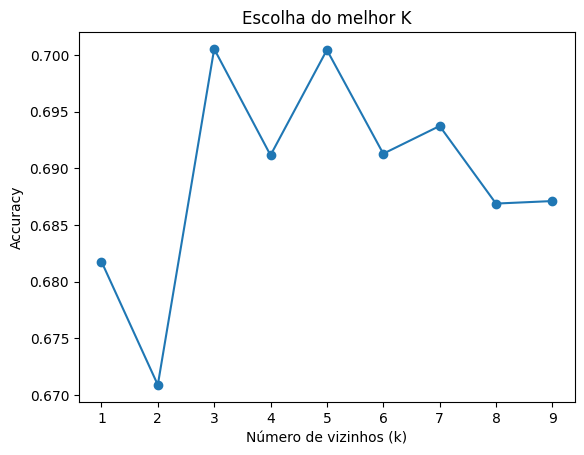

In [8]:
scores = []
for k in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_k = knn.predict(X_valid_scaled)
    scores.append(accuracy_score(y_valid, y_pred_k))

import matplotlib.pyplot as plt
plt.plot(range(1, 10), scores, marker="o")
plt.xlabel("Número de vizinhos (k)")
plt.ylabel("Accuracy")
plt.title("Escolha do melhor K")
plt.show()

O accuracy estabiliza a partir de k=3. Por isso optámos por k=3 para o modelo final.


#6. Treinar KNN

In [9]:
k_best=3
knn = KNeighborsClassifier(
    n_neighbors=k_best,
    metric="minkowski",
    p=2
)

knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

#7. Comparação entre Validação e Teste

##7.1 Avaliação da Validação

In [10]:
# Avaliar a Validação Y

y_pred = knn.predict(X_valid_scaled)

print("📊 Classification Report")
print(classification_report(y_valid, y_pred))

print("🔎 Confusion Matrix")
print(confusion_matrix(y_valid, y_pred))

📊 Classification Report
              precision    recall  f1-score   support

           0       0.67      0.69      0.68     10425
           1       0.72      0.71      0.72     12072

    accuracy                           0.70     22497
   macro avg       0.70      0.70      0.70     22497
weighted avg       0.70      0.70      0.70     22497

🔎 Confusion Matrix
[[7142 3283]
 [3454 8618]]


Conclusão: Accuracy ~0.70, classes equilibradas, precision/recall semelhantes.

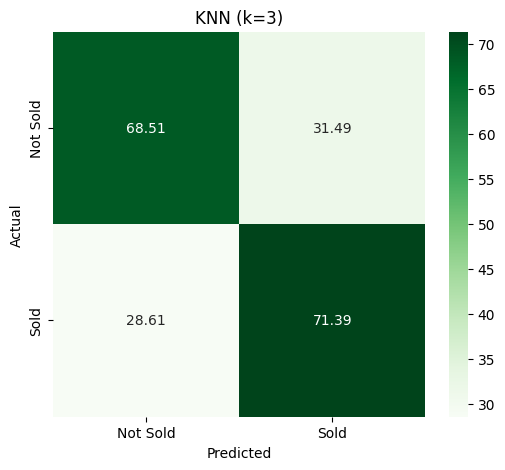

In [11]:
# Matriz de Confusão Teste (Percentual)
cm = confusion_matrix(y_valid, y_pred)
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm_pct, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=['Not Sold', 'Sold'],
            yticklabels=['Not Sold', 'Sold'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"KNN (k={3})")
plt.show()

ROC AUC (KNN): 0.750


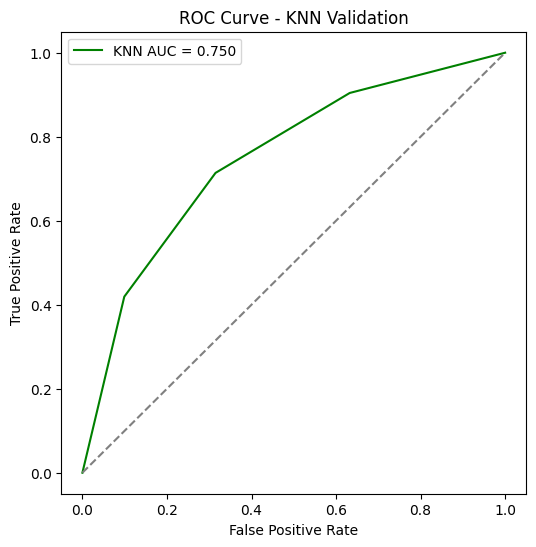

In [12]:
# Probabilidades do KNN Validação
y_proba_knn = knn.predict_proba(X_valid_scaled)[:, 1]

# AUC
auc_knn = roc_auc_score(y_valid, y_proba_knn)
print(f"ROC AUC (KNN): {auc_knn:.3f}")

# Curva ROC
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_valid, y_proba_knn)

plt.figure(figsize=(6,6))
plt.plot(fpr_knn, tpr_knn, label=f"KNN AUC = {auc_knn:.3f}", color="green")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - KNN Validation")
plt.legend()
plt.show()

Conclusão: AUC próximo de 0.7 indica um desempenho moderado; melhor que aleatório (0.5), mas não excelente.

In [13]:
# Avaliar Teste Y
y_pred = knn.predict(X_test_scaled)

print("📊 Classification Report")
print(classification_report(y_test, y_pred))

print("🔎 Confusion Matrix")
print(confusion_matrix(y_test, y_pred))


📊 Classification Report
              precision    recall  f1-score   support

           0       0.67      0.68      0.68     10425
           1       0.72      0.71      0.72     12072

    accuracy                           0.70     22497
   macro avg       0.70      0.70      0.70     22497
weighted avg       0.70      0.70      0.70     22497

🔎 Confusion Matrix
[[7134 3291]
 [3441 8631]]


##7.2 Avaliação do Test

ROC AUC (KNN): 0.750


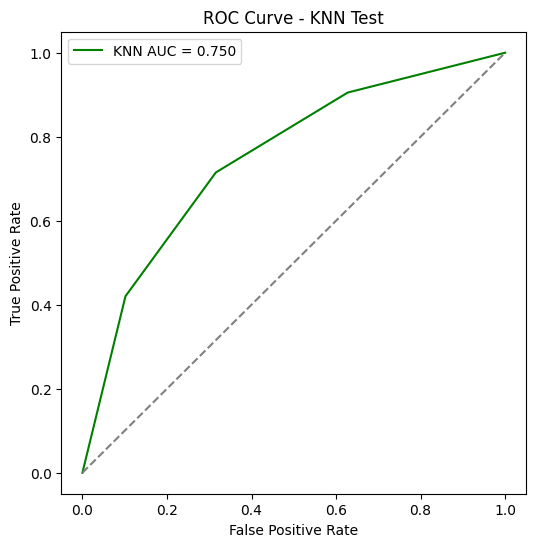

In [14]:
# Probabilidades do KNN Test

y_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]

# AUC
auc_knn = roc_auc_score(y_test, y_proba_knn)
print(f"ROC AUC (KNN): {auc_knn:.3f}")

# Curva ROC
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_proba_knn)

plt.figure(figsize=(6,6))
plt.plot(fpr_knn, tpr_knn, label=f"KNN AUC = {auc_knn:.3f}", color="green")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - KNN Test")
plt.legend()
plt.show()


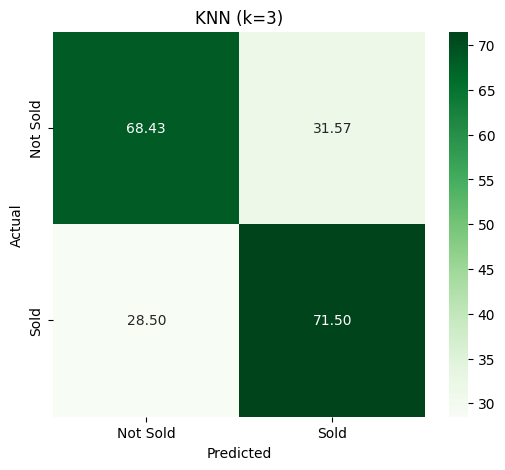

In [15]:
# Matriz de Confusão Teste (Percentual)
cm = confusion_matrix(y_test, y_pred)
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm_pct, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=['Not Sold', 'Sold'],
            yticklabels=['Not Sold', 'Sold'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"KNN (k={k_best})")
plt.show()

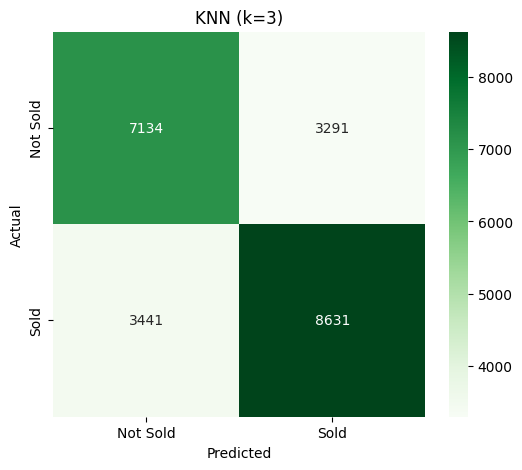

In [16]:
# Matriz de Confusão Teste (Absoluto)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=['Not Sold', 'Sold'],
            yticklabels=['Not Sold', 'Sold'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"KNN (k={k_best})")
plt.show()

Conclusão: As métricas no test são semelhantes às de validation, sugerindo que o modelo generaliza razoavelmente sem overfitting.

##7.3 Importância das Métricas

In [17]:
#Garantir que o modelo foi treinado com DataFrame

# 1) Subamostrar X_test para acelerar
n_samples = 10000
if len(X_test) > n_samples:
    X_eval, _, y_eval, _ = train_test_split(
        X_test, y_test,
        train_size=n_samples,
        stratify=y_test,
        random_state=42
    )
else:
    X_eval, y_eval = X_test, y_test

# 2) Scorer
scorer = make_scorer(f1_score)

# 3) Permutation Importance paralelizada
perm = permutation_importance(
    knn,
    X_eval, y_eval,
    n_repeats=1,
    random_state=42,
    scoring=scorer,
    n_jobs=-1
)

imp_df = (
    pd.DataFrame({
        "feature": X_eval.columns,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

print("\nPermutation Importance (KNN) — subamostrado:")
print(imp_df.head(20))



Permutation Importance (KNN) — subamostrado:
              feature  importance_mean  importance_std
0   labelling_dow_sin         0.007418             0.0
1    expiring_dow_cos         0.005049             0.0
2   selling_square_ft         0.001981             0.0
3          weight (g)         0.000906             0.0
4      StoreCluster_2         0.000052             0.0
5          Margin (%)         0.000000             0.0
6              oldpvp         0.000000             0.0
7          d_Marca 12         0.000000             0.0
8           d_Marca 1         0.000000             0.0
9          d_Marca 10         0.000000             0.0
10         d_Marca 11         0.000000             0.0
11         d_Marca 14         0.000000             0.0
12         Profit (€)         0.000000             0.0
13             newpvp         0.000000             0.0
14           discount         0.000000             0.0
15         d_Marca 23         0.000000             0.0
16         d_Marca 